In [75]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from MTAL_CACS.src.model import MTALModel
from training.dataset import CardiacNIFTIDataset
import pandas as pd
import os
from torch.utils.data import DataLoader, RandomSampler
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
from masks_auto_generation.utils import filter_3d_components
from scipy import ndimage as ndi

In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Load best model
model = MTALModel(device=device)
model.create()
# model.load_checkpoint(f"exp1/weights/best.pt")
# if args.pretrained_model:
# print("Loading base pretrained model from", args.pretrained_model)
model.load("MTAL_CACS/model/model.pt")
model = model.mtal.to(device)
model.eval()

Using device: cuda


MTAL(
  (conv_down1): Conv_down(
    (down): Conv2d(16, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (relu1): LeakyReLU(negative_slope=0.2)
    (dropout): Dropout(p=0.0, inplace=False)
    (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): LeakyReLU(negative_slope=0.2)
  )
  (conv_down2): Conv_down(
    (down): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (relu1): LeakyReLU(negative_slope=0.2)
    (dropout): Dropout(p=0.0, inplace=False)
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): LeakyReLU(negative_slope=0.2)
  )
  (conv_down3): Conv_down(
    (down): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (relu1): LeakyReLU(negative_slope=0.2)
    (dropout): Dropout(p=0

In [3]:
# Load dataset
df_test = pd.read_csv(os.path.join("data", "test.csv"))
test_dataset = CardiacNIFTIDataset(
    root="data/ExamesArya_CalcSegTraining",
    label_suffix="_mask",
    df_sample=df_test,
    normalize=True,
    strict_pairs=True,
    map_labels=False
)

In [4]:
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    pin_memory=False
)

In [47]:
def group_predictions(Y_region, Y_lesion, Xmask):
    Y_region = torch.softmax(Y_region, dim=1)  # (N,C,H,W)
    Y_lesion = torch.softmax(Y_lesion, dim=1)  # (N,C,H,W)

    # Combine lesion predictions
    Y_lesion_bin = Y_lesion.round()
    Y_lesion_bin[:,1,:,:] = Y_lesion_bin[:,1,:,:]*Xmask
    Y_lesion_bin[:,0,:,:] = 1-Y_lesion_bin[:,1,:,:]
    
    # Combine region predictions
    Y_region_bin = torch.zeros(Y_region.shape, dtype=torch.float32)
    Y_region_bin = Y_region_bin.scatter_(1,torch.argmax(Y_region, dim=1, keepdim=True) , 1)
    Y_region_multi = torch.argmax(Y_region_bin, dim=1, keepdim=True)
    
    # Combine lesion and region predictions
    Y_lesion_multi = torch.argmax(torch.cat((torch.max(Y_lesion_bin[:,0:1,:,:], Y_region_bin[:,0:1,:,:]), Y_lesion_bin[:,1:2,:,:].repeat((1,3,1,1)) * Y_region_bin[:,1:,:,:]), dim=1), dim=1, keepdim=True)
    
    # Fill predictions
    pred_lesion = Y_lesion_bin[0,1,:,:].cpu()
    pred_region = Y_region_multi[0,0,:,:].cpu()
    pred_lesion_multi = Y_lesion_multi[0,:,:,:].cpu()
    
    return pred_lesion, pred_region, pred_lesion_multi[0]

Sample ID: 313073_slice038
torch.Size([2, 512, 512]) torch.Size([512, 512]) tensor([0, 1, 2, 3], device='cuda:0')
DEBUG Máscara verdadeira
tensor([0, 1, 2, 3], device='cuda:0')
Número de pixels na classe 1 : 1
Número de pixels na classe 2: 1


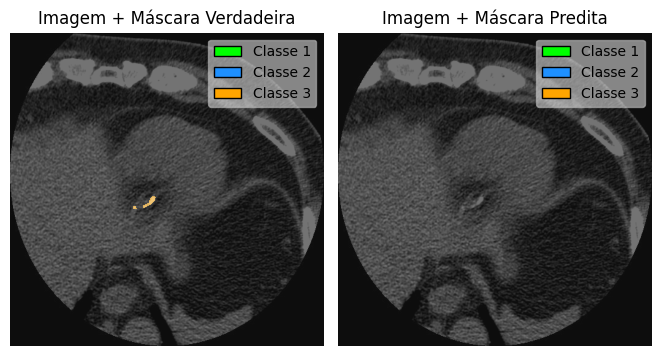

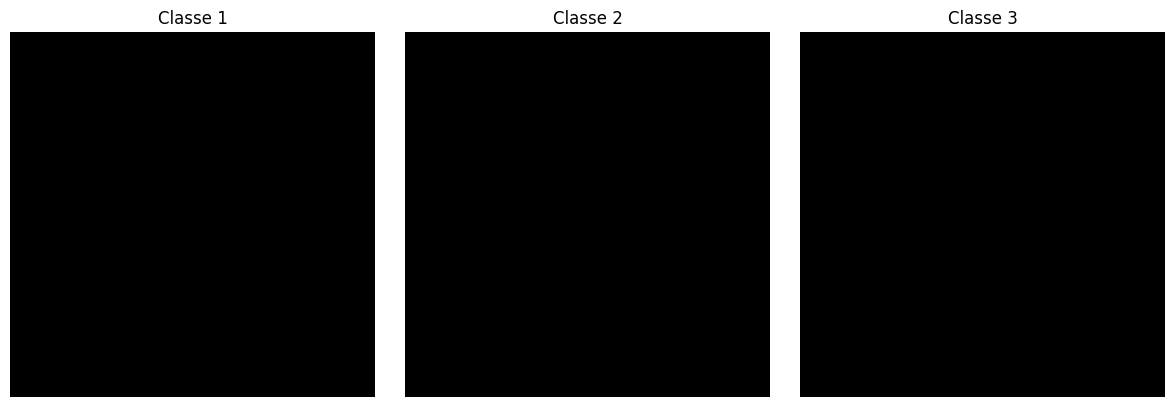

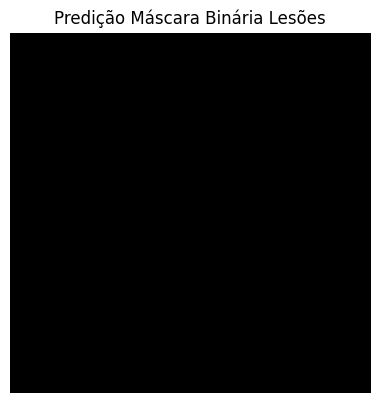

In [77]:
def unpack_batch(batch):
    # Suporta batch como (inputs, targets) ou dict
    if isinstance(batch, (list, tuple)) and len(batch) >= 2:
        return batch[0], batch[1]
    if isinstance(batch, dict):
        # tente chaves comuns
        x = batch.get('image')
        y = batch.get('label')
        id = batch.get('id')
        return x, y, id
    raise ValueError("Formato de batch não suportado")

rand_loader = DataLoader(test_dataset, batch_size=1,
                         sampler=RandomSampler(test_dataset, replacement=True))

it_loader = iter(rand_loader)  # seu DataLoader já criado
classes = [1, 2, 3]

# defina colormap e norm discretos
C = 3 + 1  # número de classes (incluindo fundo)
colors = ['black', 'lime', 'dodgerblue', 'orange'][:C]  # ajuste as cores conforme necessário
cmap = ListedColormap(colors)
bounds = np.arange(C + 1) - 0.5
norm = BoundaryNorm(bounds, cmap.N)
handles = [Patch(facecolor=cmap(norm(k)), edgecolor='k', label=f'Classe {k}') for k in classes]
while True:
    try:
        input("Pressione Enter para ver outro sample (Ctrl+C para sair)...")
        # try:
        #     batch = next(it_loader)
        # except StopIteration:
        #     it_loader = iter(test_loader)
        #     batch = next(it_loader)

        X, Y, id = unpack_batch(batch)           # X: (B,C,H,W) ou (B,1,H,W) | Y: (B,H,W)
        print(f"Sample ID: {id[0]}")
        X = X.to(device)
        #TODO: ver os labels gerados. Nao estao preenchidos 100%. Os Edges estao de outro label
        Y = Y.to(device)

        img = X[0]
        # Unormalize img
        img = test_dataset._unnormalize(img)
        mask = Y[0]
        
        # struct = ndi.generate_binary_structure(3, 2) 
        # print(struct.shape)
        
        # new_mask = torch.zeros_like(mask)
        # for c in classes:
        #     m = mask.clone()
        #     m[m!=c] = 0
        #     m[m==c] = 1
        #     print(m.shape)
        #     m_filtered = filter_3d_components(m.cpu().numpy(), min_voxels=3, min_slices=2)
        #     new_mask[m_filtered==1] = c
        # mask = new_mask.clone()

        print(img.shape, mask.shape, torch.unique(mask))

        # Forward
        with torch.no_grad():
            y_region, y_lesion = model(X)
        
        # print(X.shape, Y.shape)
        pred_lesion, pred_region, pred_lesion_multi = group_predictions(y_region.detach().cpu(), y_lesion.detach().cpu(), img[1][0].detach().cpu())
        
        # print(pred_lesion.shape, pred_region.shape, pred_lesion_multi.shape, torch.unique(pred_region), torch.unique(pred_lesion), torch.unique(pred_lesion_multi))
        
        # y_region = torch.softmax(y_region, dim=1).detach().cpu().numpy()[0]  # (C,H,W)
        # y_lesion = torch.softmax(y_lesion, dim=1).detach().cpu().numpy()[0]  # (C,H,W)
        # y_lesion = y_lesion[1] > 0.5  # (H,W) binarizado
        # y_pred = y_region * y_lesion
        # y_pred = np.argmax(y_pred, axis=0)  # (H,W)
        
        plt.figure(figsize=(10,4))
        # CT image in background and masks overlaid
        plt.subplot(1,3,1)
        plt.imshow(img[0].detach().cpu().numpy(), cmap='gray')
        plt.imshow(mask.detach().cpu().numpy(), cmap=cmap, norm=norm, alpha=0.5, interpolation='nearest')
        plt.title("Imagem + Máscara Verdadeira")
        plt.axis('off')
        leg = plt.legend(handles=handles, loc='upper right', frameon=True)
        leg.get_frame().set_alpha(0.5)          # ou: leg.get_frame().set_facecolor('none')
        
        print("DEBUG Máscara verdadeira")
        print(torch.unique(mask))
        
        pixels1 = np.sum(mask.detach().cpu().numpy() == 1)
        pixels2 = np.sum(mask.detach().cpu().numpy() == 2)
        print(f"Número de pixels na classe 1 : {pixels1}")
        print(f"Número de pixels na classe 2: {pixels2}")
        
        plt.subplot(1,3,2)
        plt.imshow(img[0].detach().cpu().numpy(), cmap='gray')
        plt.imshow(pred_lesion_multi, cmap=cmap, norm=norm, alpha=0.5, interpolation='nearest')
        plt.title("Imagem + Máscara Predita")
        plt.axis('off')
        leg = plt.legend(handles=handles, loc='upper right', frameon=True)
        leg.get_frame().set_alpha(0.5)          # ou: leg.get_frame().set_facecolor('none')
        plt.tight_layout()
        plt.show()
        
        fig, axes = plt.subplots(1, len(classes), figsize=(12, 4), squeeze=False)
        axes = axes[0]
        # y_region_pred = np.argmax(y_region, axis=0)
        # print(y_region_pred.shape)
        
        for i, c in enumerate(classes):
            axes[i].imshow((pred_region == c), cmap='gray', interpolation='nearest')
            axes[i].set_title(f"Classe {c}")
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(8,4))
        plt.subplot(1,2,1)
        plt.imshow(pred_lesion, cmap='gray', interpolation='nearest')
        plt.title("Predição Máscara Binária Lesões")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        break
    except KeyboardInterrupt:
        break

(512, 512)
(512, 512)


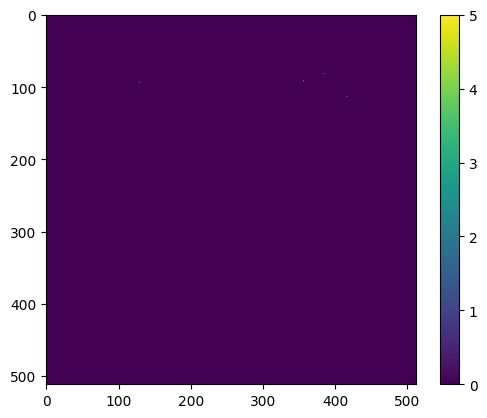

In [ ]:
fig = plt.figure()
print(slice_img.shape)
slice5 = slice_img.copy()
slice5[slice5 != 5] = 0
print(slice5.shape)
plt.imshow(slice5)
plt.colorbar()
plt.show()